In [61]:
from refine import *
import project
import time
import prody as pdy
import mdtraj as mdt
import matplotlib.pyplot as plt

%pylab inline
project.setup()
# величины амплитуд смещений (трансляций, вращение и моды (моды можно тоже по отдельности смотреть))
# График энергии энергии в log scale
# подобрать границы rmsd

Populating the interactive namespace from numpy and matplotlib


In [62]:
def confined_gradient_descent(
        rw, decrement=0.9, relative_bounds_r=(0.01, 3), relative_bounds_s=(0.01, 0.5),
        max_iter=100, save_path=False):
    """
    Performs gradient descent with respect to a special confinement.

    @param rw: system to optimize.
    @type rw: RMRestrictionWrapper
    @param decrement: fold step when choosing optimal step.
    @type decrement: float
    @param relative_bounds_r: minimum and maximum rmsd between actual intermediate state and the next one (rigid).
    @type relative_bounds_r: tuple
    @param relative_bounds_s: minimum and maximum rmsd between actual intermediate state and the next one (modes).
    @type relative_bounds_s: tuple
    @param max_iter: maximum number of iterations
    @type max_iter: int
    @param save_path: if true all intermediate states, energies and forces are returned.
        Otherwise, the function returns only final record.
    @type save_path: bool
    @return: dictionary containing all the results.
        "states" - list of all states along optimization path.
        "energies" - list of all energies along optimization path.
        "forces" - list of all forces along optimization path.
        If return_traj is false returns only last record.
    @rtype: dict
    """
    print("INITIALIZATION SATGE")
    optimization_result = {
        "states": [],
        "energies": [],
        "forces": [],
        "coords": [],
        "success": True,
    }

    optimization_result["states"].append(rw.get_position(0))
    optimization_result["energies"].append(rw.get_energy())
    optimization_result["forces"].append(rw.get_force(0))
    optimization_result["coords"].append(rw._protein_complex.get_coords(0))

    k = 0
    while k < max_iter:
        print("ITERATION", k, "START")
        position = optimization_result["states"][-1]
        energy = optimization_result["energies"][-1]
        force = optimization_result["forces"][-1]
        coords = optimization_result["coords"][-1]
        
        f_trans = force[0]
        torque = force[1]
        inertia_inv = np.linalg.inv(force[2])
        f_modes = force[3]
        w = np.sum(rw._weights[0])

        iinv_t = inertia_inv.dot(torque)
        iinv_t24 = iinv_t.dot(iinv_t) / 4
        ft24w = f_trans.dot(f_trans) / 4 / w
        tit = torque.dot(iinv_t)
        wrmsd20 = w * relative_bounds_r[0] ** 2
        wrmsd21 = w * relative_bounds_r[1] ** 2
        a = ft24w * iinv_t24
        b0 = ft24w + tit - wrmsd20 * iinv_t24
        c0 = -wrmsd20
        b1 = ft24w + tit - wrmsd21 * iinv_t24
        c1 = -wrmsd21
        roots0 = np.roots([a, b0, c0])
        roots1 = np.roots([a, b1, c1])
        tau0 = np.max(roots0) ** 0.25
        tau1 = np.max(roots1) ** 0.25
        print("tau:", tau0, tau1)

        mcoeff = (4 * w / f_modes.dot(f_modes)) ** 0.25
        mtau0 = relative_bounds_s[0] ** 0.5 * mcoeff
        mtau1 = relative_bounds_s[1] ** 0.5 * mcoeff
        print("mtau:", mtau0, mtau1)
        
        print("LINEAR SEARCH")
        while tau1 > tau0 and mtau1 > mtau0:
            trans = tau1 ** 2 / w / 2 * f_trans + position[0]
            modes = mtau1 ** 2 / 2 * f_modes + position[2]
            quat = np.quaternion(1, *(tau1 ** 2 / 2 * iinv_t))
            quat /= quat.norm()
            quat = quat * position[1]
            new_pos = [trans, quat, modes]
            
            print("TRANS")
            print(position[0])
            print(trans)
            coords1 = coords
            test_pos = [trans, quat, position[2]]
            rw.set_position(0, test_pos)
            coords2 = rw._protein_complex.get_coords(0)
            weights = rw._weights[0]
            print("TEST RMSD", rmsd(coords1, coords2, weights))
            
            rw.set_position(0, new_pos)
            new_energy = rw.get_energy()
            tau1 *= decrement * decrement
            mtau1 *= decrement * decrement
            print(new_energy)
            if new_energy < energy:
                break;
        
        print("ITERATION", k, "END")
        optimization_result["energies"].append(rw.get_energy())
        if optimization_result["energies"][-2] < optimization_result["energies"][-1]:
            optimization_result["energies"].pop()
            optimization_result["success"] = False
            break
        optimization_result["states"].append(rw.get_position(0))
        optimization_result["forces"].append(rw.get_force(0))
        optimization_result["coords"].append(rw._protein_complex.get_coords(0))
        k += 1
    return optimization_result

In [37]:
def distance(A, B):
    darr = []
    for i in range(len(A)):
        for j in range(len(B)):
            diff = A[i] - B[j]
            darr.append(np.linalg.norm(diff))
    darr = np.array(darr)
    return np.min(darr)

In [38]:
path = str((project.data_path / "may_complex") / "1dfj.pdb")
print(path)
create_system(path, tmp_file=str(project.output_path / "tmp_system.pdb"))
t0 = time.time()
pc = ProteinComplex(str(project.output_path / "tmp_system.pdb"), "charmm36.xml", ["chain A", "chain B"])
print("construction of system:", -t0 + time.time(), "sec")

@> 4416 atoms and 1 coordinate set(s) were parsed in 0.04s.


/home/semyon/PycharmProjects/DiplomaPython/data/may_complex/1dfj.pdb
write PDB(prody): 0.0374 sec
read PDB(openmm): 0.39906764030456543 sec


@> 8726 atoms and 1 coordinate set(s) were parsed in 0.06s.


add hydrogens and extra particles(openmm): 19.58729648590088 sec
write PDB(openmm): 0.09228229522705078 sec
construction of system: 10.337825298309326 sec


In [39]:
coords_0 = pc.get_coords(0)
coords_1 = pc.get_coords(1)

In [40]:
pc.set_coords(0, coords_0)
pc.set_coords(1, coords_1)

In [41]:
t0 = time.time()
mode_params = [
    {"nmodes": 10, "cutoff": 4.0},
    {"nmodes": 0}
]
rw = RMRestrictionWrapper(pc, mode_params)
print("construction of wrapper:", -t0 + time.time(), "sec")

@> Hessian was built in 0.67s.
@> 10 modes were calculated in 18.76s.


construction of wrapper: 19.521661043167114 sec


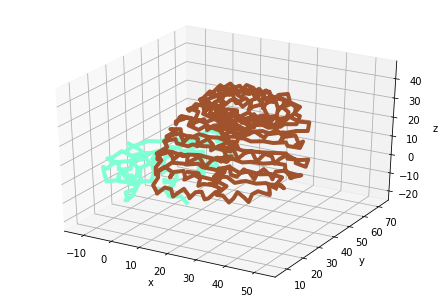

In [64]:
rw.set_position(0, [np.array([0, 0, 0]), np.quaternion(1, 0, 0, 0), np.array([0] * 10)])
pdy.showProtein(rw._protein_complex._pdy_protein)
pylab.show()

In [71]:
# господин никто
# awakenings
# chernobl series
t0 = time.time()
E = rw.get_energy()
t1 = time.time() - t0
print(f"energy calculated in {t1} seconds")
print(E)

energy calculated in 0.00028061866760253906 seconds
-3197.0488482777955


In [70]:
print(rw.get_position(0))

[array([200,   0,   0]), quaternion(0.99144486137381, 0, 0.130526192220052, 0), array([12.92439554,  4.30813185, 21.54065923,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])]


In [66]:
pos0 = rw.get_position(0)
pos1 = rw.get_position(1)
rw.set_position(0, [np.array([200, 0, 0]), np.quaternion(np.cos(np.pi * (1/24)), 0, np.sin(np.pi * (1/24)), 0), (len(coords_0)) ** 0.5 * np.array([0.3, 0.1, 0.5, *([0] * 7)])])
rw.set_position(1, [np.array([0, 0, 0]), pos1[1], pos1[2]])

In [57]:
n = len(coords_0)
mode_pos = rw.get_position(0)[2]
rotation_matrix = quaternion.as_rotation_matrix(rw.get_position(0)[1])
print(mode_pos)
i_tensor = rw._i_tensors[0]
c_tensor = rw._c_tensors[0]
d_tensor = rw._d_tensors[0]
f_tensor = rw._f_tensors[0]
weights = rw._weights[0]
print(i_tensor)
new_i_dir = build_i_tensor(rw._protein_complex.get_coords(0), c_tensor, weights)
new_i_ind = calc_inertia_tensor(rotation_matrix, mode_pos, i_tensor, d_tensor, f_tensor, weights)
print(new_i_dir)
print(new_i_ind)
print(np.linalg.norm(new_i_dir - new_i_ind))

[12.92439554  4.30813185 21.54065923  0.          0.          0.
  0.          0.          0.          0.        ]
[[231566.21298144 -61648.14820999 -38739.43495741]
 [-61648.14820999 280542.72608071 -21797.95480819]
 [-38739.43495741 -21797.95480819 274624.97462672]]
[[216737.77165998 -63248.49403031 -25360.86821748]
 [-63248.49403031 276495.20986728  -6456.85491785]
 [-25360.86821748  -6456.85491785 289236.78378449]]
[[216737.77165998 -63248.49403031 -25360.86821748]
 [-63248.49403031 276495.20986728  -6456.85491785]
 [-25360.86821748  -6456.85491785 289236.78378449]]
1.946288486735937e-09


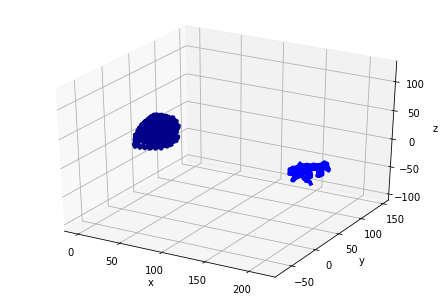

In [72]:
pdy.showProtein(rw._protein_complex._pdy_protein)
pylab.show()

In [ ]:
rw.set_position(0, result["states"][-1])
pdy.showProtein(rw._protein_complex._pdy_protein)
pylab.show()

In [58]:
result = confined_gradient_descent(rw)

INITIALIZATION SATGE
ITERATION 0 START
tau: 3.220749066873339e-05 0.0008723832581037388
mtau: 3.528908519974321e-05 0.0002495315144660826
LINEAR SEARCH
TRANS
[0 0 0]
[ 0.96066332 -2.11237347 -0.26594108]
TEST RMSD 6.999999999999981
1106802863.1724143
TRANS
[0 0 0]
[ 0.63029121 -1.38592823 -0.17448394]
TEST RMSD 4.714069613490446
53658480896.79648
TRANS
[0 0 0]
[ 0.41353406 -0.90930751 -0.11447891]
TEST RMSD 3.1295159299975577
256599830.78253058
ITERATION 0 END
ITERATION 1 START
tau: 7.228910446835415e-05 0.0019327426088092859
mtau: 0.00011497953106257805 0.0008130280611199822
LINEAR SEARCH
TRANS
[ 0.41353406 -0.90930751 -0.11447891]
[-3.14644043 -2.12709371  1.42822538]
TEST RMSD 6.999999999999991
7.155212430021619e+17
TRANS
[ 0.41353406 -0.90930751 -0.11447891]
[-1.9221652  -1.70829704  0.89768937]
TEST RMSD 4.646864643249398
29512478.036213502
ITERATION 1 END
ITERATION 2 START
tau: 0.00036972337106555477 0.009781971459343498
mtau: 0.00019671426055011579 0.0013909798759108422
LINEAR S

1.9466836226509162e+17
TRANS
[-1.32899223 -4.32191361  6.16672016]
[-1.53017959 -4.55426777  6.04293144]
TEST RMSD 0.8780159777460738
75770903.37218343
TRANS
[-1.32899223 -4.32191361  6.16672016]
[-1.46099125 -4.47436118  6.08550238]
TEST RMSD 0.5762265943497823
184685.0688658097
TRANS
[-1.32899223 -4.32191361  6.16672016]
[-1.41559679 -4.42193446  6.11343318]
TEST RMSD 0.37810757824534613
6904.341326928579
TRANS
[-1.32899223 -4.32191361  6.16672016]
[-1.38581348 -4.38753729  6.13175857]
TEST RMSD 0.24808918290168838
-3615.319691818476
TRANS
[-1.32899223 -4.32191361  6.16672016]
[-1.36627265 -4.36496931  6.14378186]
TEST RMSD 0.1627749287188805
-5353.220417996924
ITERATION 9 END
ITERATION 10 START
tau: 0.03650565888364381 0.9814107329659891
mtau: 0.030698118336950343 0.2170684764572469
LINEAR SEARCH
TRANS
[-1.36627265 -4.36496931  6.14378186]
[-2.78839724 -2.50466155  6.36602022]
TEST RMSD 6.999999999999983
740779892546.7604
TRANS
[-1.36627265 -4.36496931  6.14378186]
[-2.29932859 -3.1

In [63]:
print(result["energies"])
print(rw.get_position(0))
print(result["states"])

[756776826.4700898, 256599830.78253058, 29512478.036213502, 27906865.19336749, 398577.6618293789, 386222.1773991074, 10103.034561560216, 1365.1940471641346, -2986.087309080077, -4739.262531489746, -5353.220417996924, -5435.467629475, -6287.316303626664]
[array([-1.47420335, -4.32927541,  6.1267801 ]), quaternion(0.863260134162797, -0.117158888096585, 0.0860258587397427, -0.139425159056096), array([ 22.89283086,   7.57445242,  -1.70857104,   5.55967534,
        -3.67656603,  -0.79520783,   5.38390081, -10.33793989,
        -2.9087509 ,  16.51404068])]
[[array([0, 0, 0]), quaternion(0.99144486137381, 0, 0.130526192220052, 0), array([12.92439554,  4.30813185, 21.54065923,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])], [array([ 0.41353406, -0.90930751, -0.11447891]), quaternion(0.976768611785319, -0.0843296666019541, 0.0877921475672471, -0.104764119916472), array([12.19526583,  1.39065939, 14.89685803, -2.35708752,  2.83243749,
       -

In [59]:
full_list = result["coords"]
n_states = len(full_list)

trj = None
for i in range(n_states):
    pc.set_coords(0, full_list[i])
    with open(project.output_path / "inter_pdb.pdb", "w") as input_file:
        pc._omm_protein.writeFile(positions=pc._omm_protein.positions,
                                   topology=pc._omm_protein.topology,
                                   file=input_file)
    if trj is not None:
        trj = trj.join(mdt.load(str(project.output_path / "inter_pdb.pdb")))
    else:
        trj = mdt.load(str(project.output_path / "inter_pdb.pdb"))
    print(trj.xyz.shape)

(1, 8726, 3)
(2, 8726, 3)
(3, 8726, 3)
(4, 8726, 3)
(5, 8726, 3)
(6, 8726, 3)
(7, 8726, 3)
(8, 8726, 3)
(9, 8726, 3)
(10, 8726, 3)
(11, 8726, 3)
(12, 8726, 3)
(13, 8726, 3)


In [60]:
trj.save_pdb(str(project.output_path / "trajectory3.pdb"))

In [ ]:
step = -3
T = np.array([step, 0, 0])

ref_coords = pc.get_coords(1)
old_coords = pc.get_coords(0)

n = len(old_coords)
T_span = np.tile(T, n).reshape((n, 3))


X = [0]
E = [pc.get_energy()]
D = [distance(old_coords, ref_coords)]
for i in range(15):
    new_coords = old_coords + T_span
    old_coords = new_coords
    pc.set_coords(0, new_coords)
    E.append(pc.get_energy())
    D.append(distance(old_coords, ref_coords))
    X.append(step * (i + 1))
    print(i + 1, end=" ")
    

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X, E)
ax.set_yscale("linear")
ax.grid()
plt.show()

In [23]:
E

-11108.484147373545

In [73]:
E1 = result["energies"] - np.min(E) + 1

In [74]:
E1

array([ 7.56780025e+08,  2.56603029e+08,  2.95156761e+07,  2.79100632e+07,
        4.01775711e+05,  3.89420226e+05,  1.33010834e+04,  4.56324290e+03,
        2.11961539e+02, -1.54121368e+03, -2.15517157e+03, -2.23741878e+03,
       -3.08926746e+03])

/home/semyon/mipt/GPCR-TEAM/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/semyon/mipt/GPCR-TEAM/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


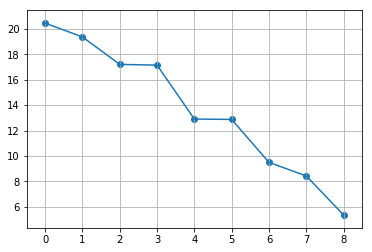

In [77]:
fig, ax = plt.subplots()
ax.plot(range(len(E1)), np.log(E1)) # тобы точки было видно
ax.scatter(range(len(E1)), np.log(E1))
ax.set_yscale("linear")
ax.grid()
plt.show()

In [27]:
rw._protein_complex.get_coords(0)

array([[ 86.94921098, -32.1553179 ,   2.57630454],
       [ 87.4318867 , -32.23419678,   1.63233754],
       [ 87.64700711, -32.37348674,   3.34214153],
       ...,
       [ 63.88739034, -30.9521773 ,  25.04640989],
       [ 62.22839047, -31.6021048 ,  25.07395235],
       [ 63.65730722, -33.87989076,  28.04677872]])